In [ ]:
!pip install mecab-python3 unidic-lite matplotlib numpy matplotlib-fontja

# 単語分析

#### single book test

In [ ]:
import MeCab

path = "./dataset/akutagawa/ababababa.txt"

def read_file(path):
    f = open(path, encoding="shift_jis")
    return f.read()

tagger = MeCab.Tagger()

text = read_file(path)

word_count = {}

node = tagger.parseToNode(text)

while node:
    word = node.surface
    if word in word_count.keys():
        count = word_count[word]
        word_count[word] = count + 1
    else:
        word_count[word] = 1
    node = node.next
    
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
print(word_count)

#### single author test

In [ ]:
import os
import MeCab

author_path = "./dataset/akutagawa"
word_count = {}

def scan_file(path) -> list[str]:
    try:
        with os.scandir(path) as entries:
            items = [entry.name for entry in entries if entry.is_file()]
        return items
    except Exception as e:
        print(e)


def read_file(path):
    f = open(path, encoding="shift_jis")
    return f.read()

tagger = MeCab.Tagger()


files = scan_file(author_path)
for i, file in enumerate(files):
    text = read_file(f'{author_path}/{file}')

    node = tagger.parseToNode(text)

    while node:
        word = node.surface
        if word in word_count.keys():
            count = word_count[word]
            word_count[word] = count + 1
        else:
            word_count[word] = 1
        node = node.next
    
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
print(word_count)

## bast author word

In [ ]:
import os
import MeCab


folder_path = "./dataset"
author_word_count = {}

def scan_file(path) -> list[str]:
    try:
        with os.scandir(path) as entries:
            items = [entry.name for entry in entries if entry.is_file()]
        return items
    except Exception as e:
        print(e)
        
def scan_folder(path) -> list[str]:
    try:
        with os.scandir(path) as entries:
            items = [entry.name for entry in entries]
        return items
    except Exception as e:
        print(e)


def read_file(path):
    f = open(path, encoding="shift_jis")
    return f.read()

tagger = MeCab.Tagger()


folders = scan_folder(folder_path)
for i, folder in enumerate(folders):
    word_count = {}
    files = scan_file(f'{folder_path}/{folder}')
    for file in files:
        text = read_file(f'{folder_path}/{folder}/{file}')

        node = tagger.parseToNode(text)

        while node:
            word = node.surface
            if word in word_count.keys():
                count = word_count[word]
                word_count[word] = count + 1
            else:
                word_count[word] = 1
            node = node.next
    word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    author_word_count[folder] = word_count
    
print(author_word_count)

{'akutagawa': [('、', 3190), ('の', 2679), ('。', 2275), ('に', 2110), ('は', 1913), ('た', 1900), ('を', 1692), ('て', 1258)], 'dazai': [('、', 7067), ('。', 3465), ('の', 3173), ('て', 2899), ('に', 2271), ('は', 2232), ('た', 1739), ('を', 1637)], 'mori': [('の', 2852), ('、', 2633), ('に', 2540), ('て', 2274), ('。', 2176), ('は', 1957), ('を', 1862), ('た', 1380)]}


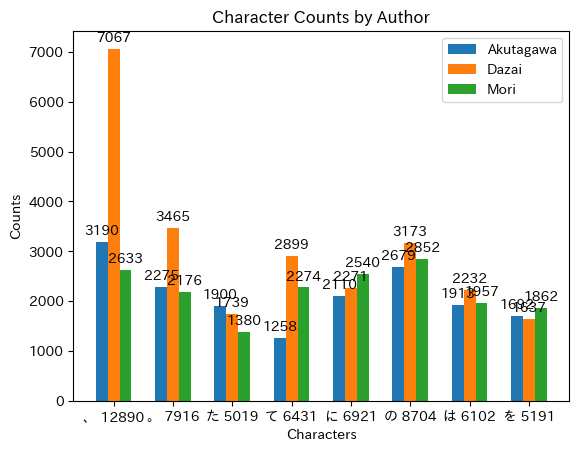

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_fontja

result = {key: value[:8] for key, value in author_word_count.items()}
print(result)

akutagawa_list = [item[0] for item in result['akutagawa']]
dazai_list = [item[0] for item in result['dazai']]
mori_list = [item[0] for item in result['mori']]

# 統合リストを作成し、重複を無視
labels = list(set(akutagawa_list + dazai_list + mori_list))

# 各作家のデータを整形
akutagawa_counts = [dict(result['akutagawa']).get(label, 0) for label in labels]
dazai_counts = [dict(result['dazai']).get(label, 0) for label in labels]
mori_counts = [dict(result['mori']).get(label, 0) for label in labels]

total_counts = [(label, akutagawa_counts[i] + dazai_counts[i] + mori_counts[i]) for i, label in enumerate(labels)]

# ラベルごとに値をまとめる
combined = list(zip(total_counts, labels, akutagawa_counts, dazai_counts, mori_counts))

# 目的のリストに従ってソート
sorted_combined = sorted(combined, key=lambda x: x[0])  # ここではtotal_countをキーにソート

# ソート後に分解
total_counts, labels, akutagawa_counts, dazai_counts, mori_counts = zip(*sorted_combined)

labels = [f'{a} {b[1]}' for a, b in zip(labels, total_counts)]

# グラフを描画
x = np.arange(len(labels))  # ラベルの位置
width = 0.2  # バーの幅

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, akutagawa_counts, width, label='Akutagawa')
bars2 = ax.bar(x, dazai_counts, width, label='Dazai')
bars3 = ax.bar(x + width, mori_counts, width, label='Mori')

# ラベルを追加
ax.set_xlabel('Characters')
ax.set_ylabel('Counts')
ax.set_title('Character Counts by Author')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# バーのラベルを表示
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # バーの上に少しずらして表示
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.show()
